# Numpy version test on synthetic data

In [1]:
import sys
import os

In [2]:
# %load ~/Desktop/defaults.py
#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#sys.path.append(os.path.abspath("../code/"))

In [4]:
#from quigly import *

In [5]:
# %load ../code/quigly.py
import numpy as np

def get_C_j(phi_a, phi_b, phi_c):
    '''Return the GMM covariance matrix given phi parameters'''
    v11 = np.exp(2.0*phi_a)
    v12 = phi_c*np.exp(phi_a)
    v22 = phi_c**2 + np.exp(2.0*phi_b)
    C_j = np.matrix([[v11, v12],[v12, v22]])
    return C_j

def get_gmm_j(x, y, x_j, y_j, C_j):
    '''Returns the j^th normalized Gaussian mixture model'''
    x = x - x_j
    y = y - y_j
    rr = np.stack([x,y], axis=0)
    exp_arg = np.sum(rr * np.linalg.solve(C_j, rr), axis=0)
    gmm_j_raw = np.exp(-0.5 * exp_arg)
    normalization = 2.0*np.pi*np.sqrt(np.linalg.det(C_j))
    gmm_j = 1.0/normalization * gmm_j_raw
    return gmm_j


def gmm_z_js(theta_js):
    '''Return the GMM z_j's given components and theta_js'''
    z_js = np.ones(len(theta_js)+1)
    for j, theta_j in enumerate(theta_js):
        z_js[j+1] = z_js[j] + np.exp(-theta_js[j])
    z_js = z_js / np.sum(z_js)
    return z_js


def compute_model_a(x, y, z_js, x_js, y_js, phi_as, phi_bs, phi_cs):
    '''Takes in x, y and GMM kernel params, returns model'''
    N_GMM, = x_js.shape
    gmm_out = 0.0
    for j in range(N_GMM):
        C_j = get_C_j(phi_as[j], phi_bs[j], phi_cs[j])
        gmm_out += z_js[j] * get_gmm_j(x, y, x_js[j], y_js[j], C_j)
    return gmm_out

def get_f_star_nocov(A, sigma_r, d):
    '''Compute the profile likelihood of the stellar fluxes'''
    #For now ignore the covariance matrix, assume homoscedastic
    ATA = np.dot(A.T, A / sigma_r)
    f_star = np.linalg.solve(ATA, np.dot(A.T, d/sigma_r))
    return f_star

def get_A_matrix(x, y, x_c, y_c, kernel_params):
    '''Return the column-wise concatenated A matrix'''
    N_stars = len(x_c)
    xx = x[:, np.newaxis] - x_c.T
    yy = y[:, np.newaxis] - y_c.T
    A_matrix = np.zeros(xx.shape)
    for i in range(N_stars):
        z_js, x_js, y_js, phi_as, phi_bs, phi_cs = kernel_params.T
        A_matrix[:, i] = compute_model_a(xx[:,i], yy[:,i], 
                                         z_js, x_js, y_js, phi_as, phi_bs, phi_cs)
    return A_matrix

def split_params(params, N_star, N_GMM):
    '''Split/clean all parameters into star and Kernel parameters'''
    star_params = params[0:N_star*2].reshape((N_star, -1))
    fixed_gmm_params = np.array([1, 0, 0])
    kern_params = np.hstack([fixed_gmm_params, params[N_star*2:]]).reshape((N_GMM, -1))
    kern_params[:, 0] = gmm_z_js(kern_params[1:, 0])
    return star_params, kern_params

def lnlike(params):
    '''Return the likelihood given the parameters'''
    star_params, kern_params = split_params(params, 4, 3)

    x_c, y_c = star_params[0, :], star_params[1, :]

    # Just a homoscedastic noise matrix for now
    #C_noise_matrix = get_C_matrix(sigma_r, N_pix)

    # Get the design matrix for stellar fluxes
    A_matrix = get_A_matrix(x, y, x_c, y_c, kern_params)

    # Compute the profile likelihood for stellar fluxes
    f_star = get_f_star_nocov(A_matrix, sigma_r, data)

    model = np.dot(A_matrix, f_star)
    resid = data - model
    lnlike_out = np.dot(resid.T, resid / yerr**2)
    return lnlike_out

In [6]:
star_true = np.array([[10.3, 20.5],
                        [83.1, 45.3],
                        [60.8, 80.9],
                        [80.8, 10.5]])

f_true = np.array([520.5, 1403.9, 3511.1, 1590.9])*4.0

x_ctrue, y_ctrue = star_true[:, 0], star_true[:, 1]

kern_true = np.array([   [0.50,  0.0,  0.0, 0.8, 0.5, 0.1],
                         [0.35,  2.5, -3.1, 0.2, 0.2, 0.5],
                         [0.15, -9.9,  0.5, 1.5, 2.2, 0.2] ] )

In [7]:
# Data preparation.  This should happen outside the likelihood!

sigma_r = 4.0 # read noise
yerr = sigma_r
data_2D = np.load('../data/synthetic_100x100.npy')
nx_pix, ny_pix = data_2D.shape
xpix = np.arange(0, nx_pix, 1)
ypix = np.arange(0, ny_pix, 1)

xv, yv = np.meshgrid(xpix, ypix)
x = xv.reshape(-1)
y = yv.reshape(-1)

data = data_2D.reshape(-1)

N_pix = np.shape(data)

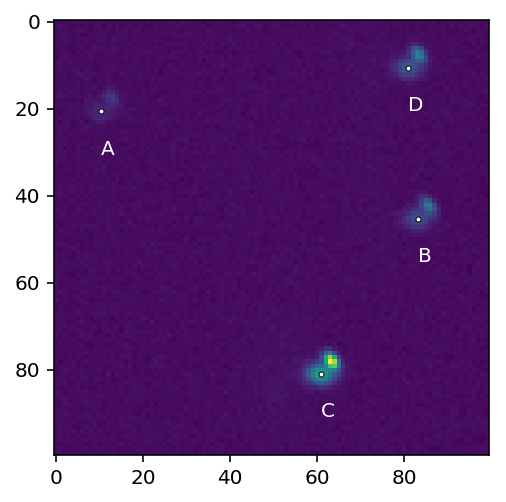

In [8]:
plt.imshow(data_2D)
for i in range(4):
    plt.plot(x_ctrue[i], y_ctrue[i], 'ko', ms=2)
    plt.plot(x_ctrue[i], y_ctrue[i], 'wo', ms=1)
    plt.text(x_ctrue[i], y_ctrue[i]+10, 'ABCD'[i], color='w')

## Compute the ln likelihood for the image

In [9]:
kern_guess = np.hstack([                  [0.8, 0.5, 0.1],
                         [0.3,  2.5, -3.1, 0.2, 0.2, 0.5],
                         [0.6, -9.9,  0.5, 1.5, 2.2, 0.2] ] )

In [10]:
params = np.hstack((star_true.reshape(-1), kern_guess))

In [11]:
N_star = 4
N_GMM = 3

In [12]:
%%timeit
lnlike(params)

5.91 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Woohoo it computes!  However, we have not tested the code to verify that we get what we expect!